In [13]:
using Polynomials, Random, Plots, Statistics
include("lagrange_interpolation.jl")
include("newton_interpolation.jl")
include("interoplations_time_comparison.jl")
include("neville_alghoritm.jl")

nevilleAlgo (generic function with 1 method)

In [2]:
a,b = 1.6,6.9
original_function(x) = sin(b*x)*exp(-(a*x))

x_min = 0
x_max = 5

x_samples = sort(rand(15) * (x_max - x_min) .+ x_min)
y_samples = original_function.(x_samples)
n = length(x_samples)
x_vals_universal = range(x_min, x_max, length=100)
# nothing

0.0:0.050505050505050504:5.0

### Zadanie 1

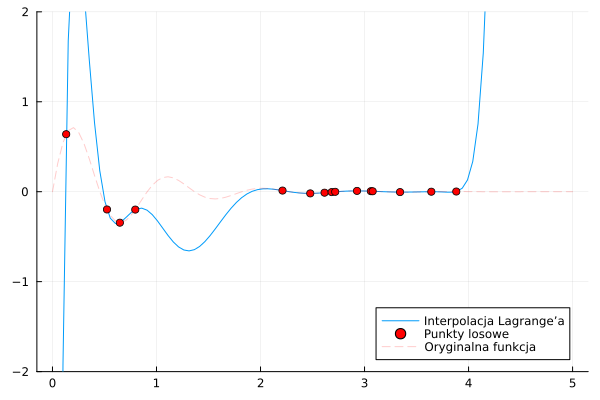

In [3]:
y_vals_lagrange = [lagrange_interpolation(x_samples, y_samples, x) for x in x_vals_universal]

plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a",ylims=(-2,2))
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal),label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

### Zadanie 2

##### Wielomian interpolacyjny Newtona

Postać ogólna:

$$
P_n(x) = f[x_0] + f[x_0, x_1](x - x_0) + f[x_0, x_1, x_2](x - x_0)(x - x_1) + \dots + f[x_0, x_1, \dots, x_n](x - x_0)(x - x_1) \dots (x - x_{n-1})
$$

---
Można uprościć do

$$
P_n(x) = f[x_0] + (x - x_0) [ f[x_0, x_1] + (x - x_1)[ f[x_0, x_1, x_2] + \dots + f[x_0, x_1, \dots, x_n] \dots (x - x_{n-1}) ]]
$$




![Wzór newtona cuted.png](<attachment:Wzór newtona cuted.png>)
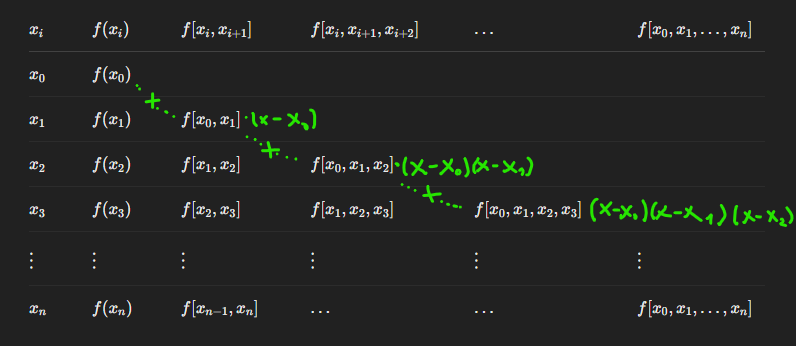

#### Newton Visualisation

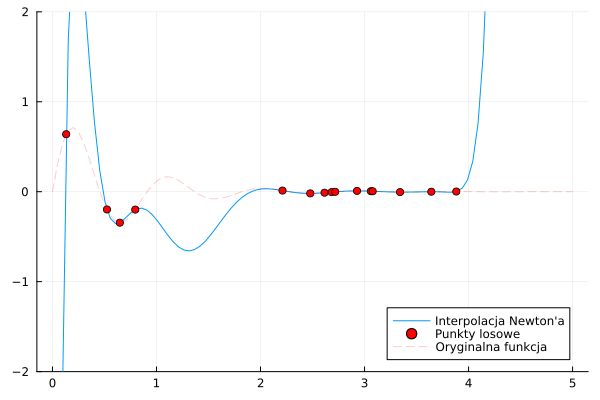

In [4]:
newt = NewtonInterpolation(x_samples, y_samples)

y_vals_newton = [NewtonHorner(newt, x, x_samples) for x in x_vals_universal]

plot(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a",ylims=(-2,2))
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

### Zadanie 3

#### Wielomian z pakietu Polynomials

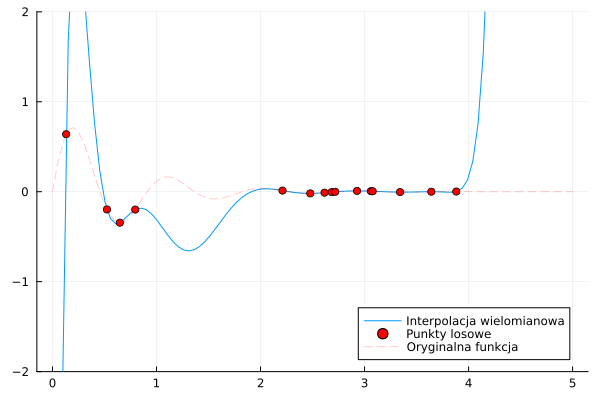

In [5]:
using Polynomials
p = Polynomials.fit(Polynomial, x_samples, y_samples)

y_vals_polynomials = [p(x) for x in x_vals_universal]

plot(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa",ylims=(-2,2))
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

#### Porównanie metod na jednym wykresie

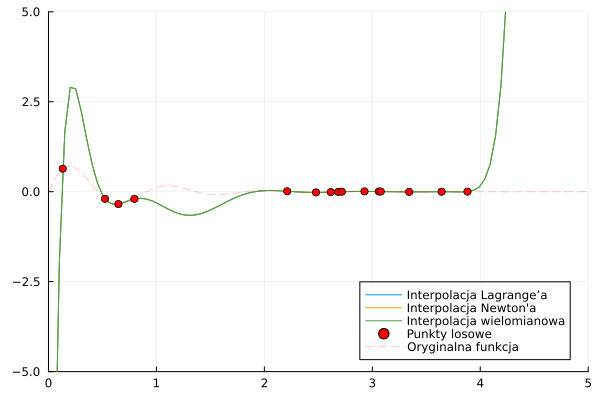

In [6]:

plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a",xlims=(0,x_max),ylims=(-5,5))
plot!(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a",color=:orange)
plot!(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")

scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

Wygląda na to że wszystkie tworzą praktycznie takie same wykresy 👌 

Pewnie dlatego że konstruują ten sam wielomian interpolacyjny tylko na różne sposoby 🐱‍👤

-> Jeśli masz n punktów, to każda z tych metod tworzy dokładnie ten sam unikalny wielomian stopnia n−1, który przechodzi przez te punkty.

### Zadanie 4

Przygotowanie danych

In [7]:
lag_avg, lag_sd, newt_prep_avg, newt_prep_sd, newt_avg, newt_sd, 
poly_prep_avg, poly_prep_sd, poly_avg, poly_sd,x_test_vals = interpolations_time_comparision()


(Any[0.29683651999999994, 0.51485741, 0.81101879, 1.1676323300000002, 1.5700820300000002, 2.0763666300000003, 2.5997261700000007, 3.2139159399999997], Any[0.0026304840892885134, 0.004905061352532813, 0.007144968618926508, 0.014778921875206083, 0.004535886325748394, 0.021922434375875256, 0.019584731080560972, 0.04466004691471887], Any[0.00540994, 0.00634985, 0.01117394, 0.01333789, 0.017802929999999998, 0.023613829999999995, 0.02848539, 0.03514004], Any[0.0032088637955236155, 0.0004285991995896503, 0.002238162329630668, 0.0003144298948538096, 0.0005293466729007664, 0.0014785487787767509, 0.0012542361167481812, 0.0034453465154546587], Any[0.00026244999999999996, 0.00046499000000000003, 0.00097807, 0.0015135600000000002, 0.00207737, 0.0038784199999999996, 0.007381219999999999, 0.010062100000000001], Any[2.7009350232836038e-5, 3.051332859951897e-5, 6.079024135866254e-5, 3.7211891767133926e-5, 7.844052311571271e-5, 0.0004828740733013803, 0.0005081769328797906, 0.0005574199095435645], Any[0.

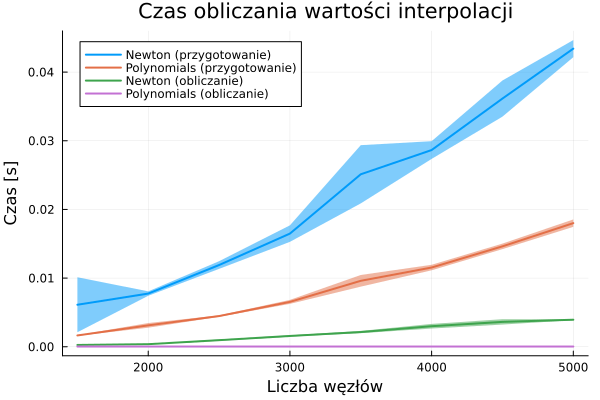

In [ ]:
# Czasy przygotowania
plot(x_test_vals, newt_prep_avg;
     ribbon = newt_prep_sd,
     label = "Newton (przygotowanie)",
     xlabel = "Liczba węzłów",
     ylabel = "Czas [s]",
     title = "Czas przygotowania struktur",
     lw = 2)

plot!(x_test_vals, poly_prep_avg;
      ribbon = poly_prep_sd,
      label = "Polynomials (przygotowanie)",
      lw = 2)

# Czasy wyliczania wartości
plot!(x_test_vals, newt_avg;
     ribbon = newt_sd,
     label = "Newton (obliczanie)",
     xlabel = "Liczba węzłów",
     ylabel = "Czas [s]",
     title = "Czas obliczania wartości interpolacji",
     lw = 2)

plot!(x_test_vals, poly_avg;
      ribbon = poly_sd,
      label = "Polynomials (obliczanie)",
      lw = 2)

# plot!(x_test_vals, lag_avg;
#       ribbon = lag_sd,
#       label = "Lagrange (obliczanie)",
#       lw = 2)


#### Zadanie 5

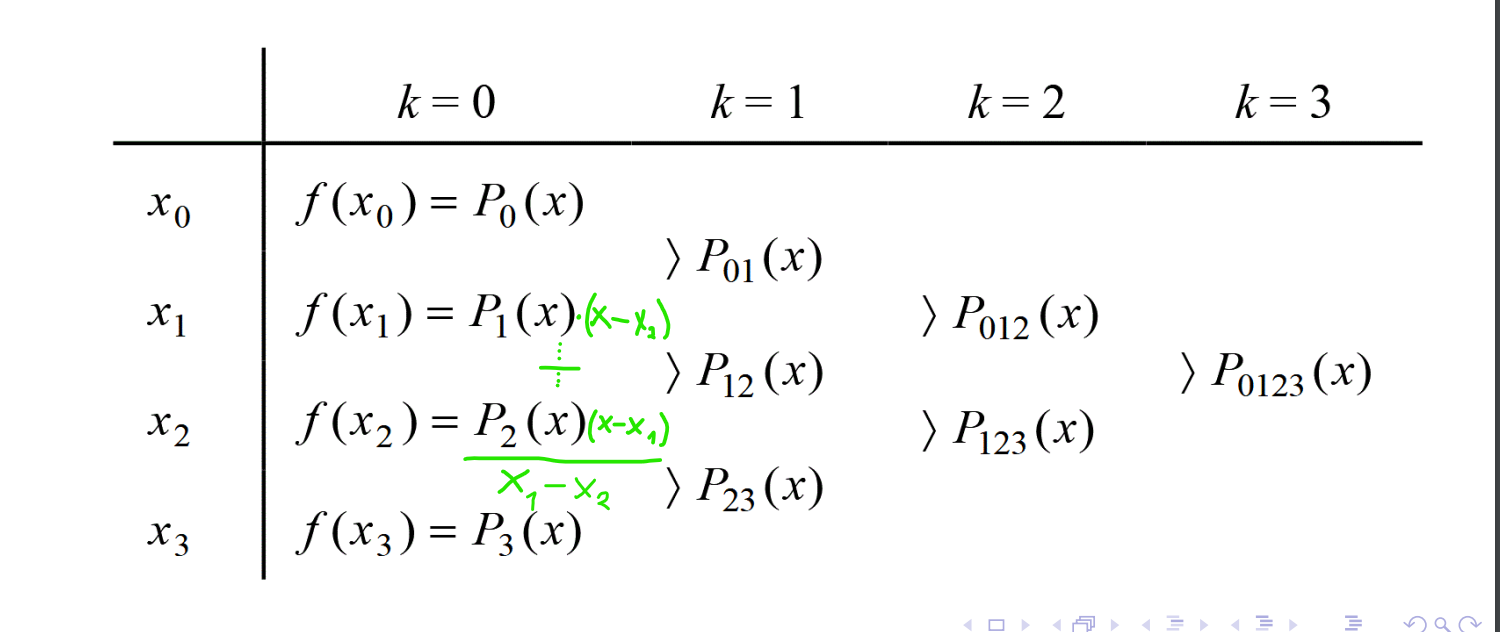

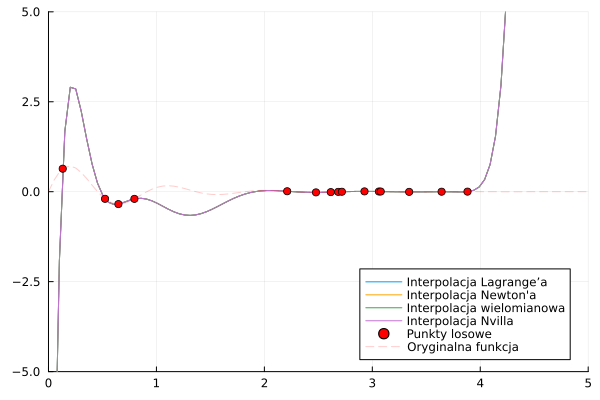

In [9]:
y_vals_nville = [nevilleAlgo(x_samples,y_samples,x) for x in x_vals_universal]


plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a",xlims=(0,5),ylims=(-5,5))
plot!(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a",color=:orange)
plot!(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")
plot!(x_vals_universal, y_vals_nville, label="Interpolacja Nvilla")

scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

In [ ]:
# Tworzymy przykładową tablicę 2D (macierz)
matrix = [[1 ,2, 3],[ 4, 5, 6], [7, 8, 9]]

# Drukujemy tablicę 2D
println("Tablica 2D:")
for row in matrix
    println(row)
end

print(matrix[1][1])
matrix2  = zeros(3,3)
for el in matrix2
    print(el)
end 

Tablica 2D:
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
10.00.00.00.00.00.00.00.00.0

#### Zadanie 6

Rungego efekt

In [30]:
function build_indices_with_history(N)
    history = []

    # Startujemy z 3 punktami: początek, środek i koniec
    idx = [1, div(N + 1, 2), N]
    push!(history, copy(idx))

    while true
        new_pts = [div(idx[i] + idx[i+1], 2) for i in 1:(length(idx) - 1)]
        all_in = all(x -> x in idx, new_pts)
        if all_in
            break
        end
        idx = sort(unique(vcat(idx, new_pts)))
        push!(history, copy(idx))
    end

    return history
end

# Przykład użycia:
steps = build_indices_with_history(33)
for (i, step) in enumerate(steps)
    println("Krok $i: $step")
end


Krok 1: [1, 17, 33]
Krok 2: [1, 9, 17, 25, 33]
Krok 3: [1, 5, 9, 13, 17, 21, 25, 29, 33]
Krok 4: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33]
Krok 5: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


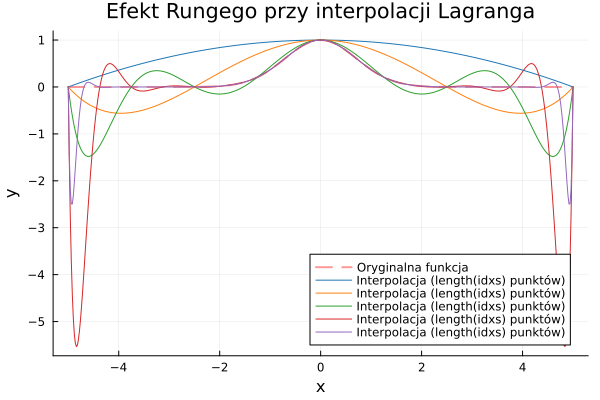

In [43]:
using Plots

# Funkcja Rungego
runge(x) = 2.71^(-x^2)

# Punkty na odcinku [0, 10]
x_full = range(-5, 5, length=33)
y_full = runge.(x_full)

# Siatka do rysowania
x_vals_universal = range(-5, 5, length=500)
y_vals_original = runge.(x_vals_universal)

colors = palette(:tab10)
plot(x_vals_universal, y_vals_original, label="Oryginalna funkcja", linestyle=:dash, color=:red, lw=2,alpha=0.4)


for (i, idxs) in enumerate(steps)
    x_pts = [x_full[index] for index in  idxs]
    y_pts = y_full[idxs]
    y_interp = build_and_eval_newton(x_pts, y_pts, x_vals_universal)
    plot!(x_vals_universal, y_interp, label="Interpolacja ($length(idxs) punktów)", color=colors[mod1(i, length(colors))])
end
plot!(xlabel="x", ylabel="y", title="Efekt Rungego przy interpolacji Lagranga")